# **MOD007893 TRI2 F01CAM : ASSIGNMENT 010**
# **Section 1: Impact Analysis of Renewable Energy Adoption in the UK to Achieve Net-Zero Goals by 2050 :Exploratory Data Analysis**

#  **SID : 2144965**
#  **GROUP : TECHIE PENTA**




In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO
from bs4 import BeautifulSoup
from urllib import parse
import warnings

# ignore Warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [245]:
pd.options.display.float_format = '{:.2f}'.format

#### Defining a function for plotting to avoid repeating the same thing

In [246]:
def plotter_func(series, ylabel=None, title=None):
    ax = plt.figure(figsize=(10,6))
    
    #remove legend if it's just one series
    if len(series.columns) == 1:
        ax = sns.lineplot(data=series)
        legend = ax.get_legend()
        if legend:
            legend.remove()
    else:
        ax = sns.lineplot(data=series)
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Year')
    return ax

# Data Gathering from different sources

# Electricity Generation Mix of the UK

In [247]:
query = '''SELECT "DATETIME", "GAS", "COAL", "NUCLEAR", "WIND", "HYDRO", "IMPORTS", "BIOMASS", "OTHER", "SOLAR" FROM  "f93d1835-75bc-43e5-84ad-12472b180a98" ORDER BY "_id" ASC '''
params = {'sql': query}
    
response = requests.get("https://api.nationalgrideso.com/api/3/action/datastore_search_sql", params = parse.urlencode(params))
data = response.json()["result"]
Elec_Gen_Mix = pd.DataFrame(data["records"])

In [248]:
Elec_Gen_Mix = Elec_Gen_Mix.astype({col: float for col in ['NUCLEAR', 'GAS', 'BIOMASS', 'COAL', 'OTHER', 'SOLAR','IMPORTS', 'WIND', 'HYDRO']})
Elec_Gen_Mix['GB_Renewable_Energy'] = Elec_Gen_Mix['WIND'] + Elec_Gen_Mix['HYDRO'] + Elec_Gen_Mix['IMPORTS'] + Elec_Gen_Mix['BIOMASS'] + Elec_Gen_Mix['SOLAR']
Elec_Gen_Mix['GB_Non_Renewable_Energy'] = Elec_Gen_Mix['GAS'] + Elec_Gen_Mix['COAL']
Elec_Gen_Mix['Nuclear_Energy_et_al'] = Elec_Gen_Mix['NUCLEAR'] + Elec_Gen_Mix['OTHER']
Elec_Gen_Mix['Date'] = pd.to_datetime(Elec_Gen_Mix['DATETIME']).dt.tz_localize(None).dt.floor('D')
Elec_Gen_Mix = Elec_Gen_Mix.rename(columns={'Date': 'Date'})
Elec_Gen_Mix = Elec_Gen_Mix.set_index('Date')
Elec_Gen_Mix = Elec_Gen_Mix.loc[:, ['GB_Renewable_Energy', 'GB_Non_Renewable_Energy', 'Nuclear_Energy_et_al']]
Elec_Gen_Mix = Elec_Gen_Mix.resample('D').sum()

# Convert the numbers to integers
Elec_Gen_Mix = Elec_Gen_Mix.astype(int)

# Print recent records
print(Elec_Gen_Mix.head())

            GB_Renewable_Energy  GB_Non_Renewable_Energy  Nuclear_Energy_et_al
Date                                                                          
2009-01-01               107122                  1355251                335246
2009-01-02                44652                  1610219                307150
2009-01-03                56378                  1603344                278319
2009-01-04                44173                  1645448                262475
2009-01-05                34957                  1940694                246250


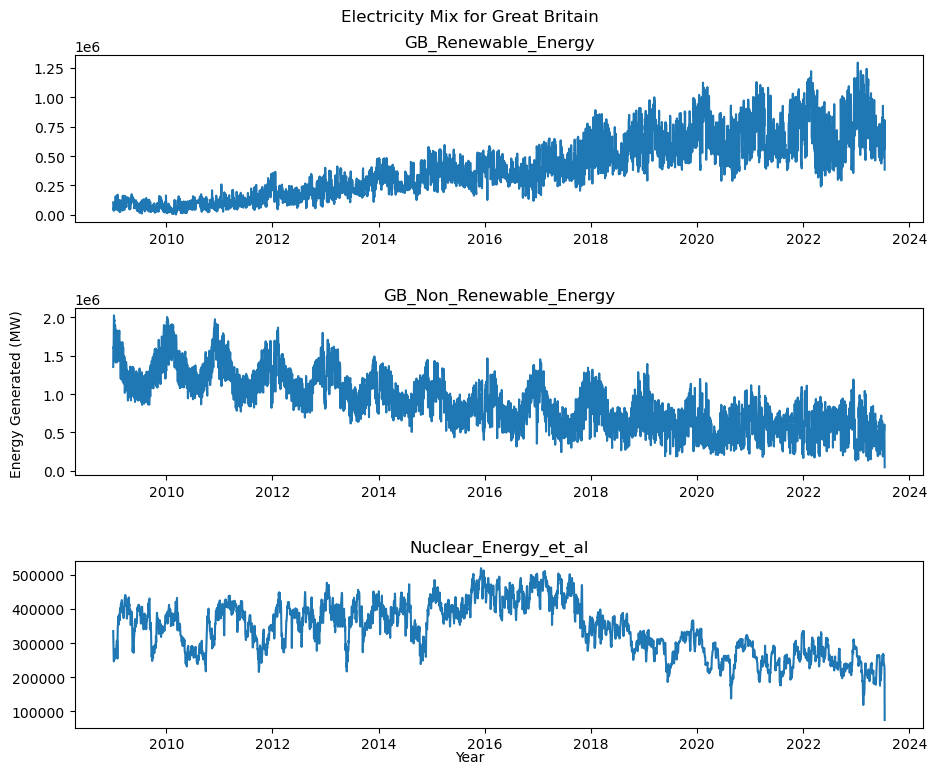

In [249]:
# create a subplot for the electricity generation mix
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# loop over each time series column and plot it in its own subplot
for i, col in enumerate(Elec_Gen_Mix.columns):
    axs[i].plot(Elec_Gen_Mix.index, Elec_Gen_Mix[col])
    axs[i].set_title(col)

# set common x and y axis labels
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(0.04, 0.5, 'Energy Generated (MW)', va='center', rotation='vertical')

# adjust layout and padding
fig.tight_layout(pad=3.0)
plt.suptitle("Electricity Mix for Great Britain");

#### It can be seen that Renewable energy adoption is steadily increasing in the UK

# Accounting for Number of Households

In [250]:
Elec_Con_UK = pd.ExcelFile('ECUK_2022_Intensity_tables.xlsx')
Households_df = pd.read_excel(Elec_Con_UK, 'Table I3', header=4, usecols=['Year', "No Households ('000s)"])

Households_df = Households_df.loc[lambda df: df.index <= 51]

Households_df['Year'] = pd.PeriodIndex(pd.to_datetime(Households_df['Year'], format='%Y'), freq='D').to_timestamp()

Households_df = Households_df.set_index('Year')

Households_df = Households_df.rename(columns={"No Households ('000s)": 'Households'})

# Convert the numbers to integers
Households_df = Households_df.astype(int)

# Print recent records
print(Households_df.tail())

            Households
Year                  
2017-01-01       27226
2018-01-01       27576
2019-01-01       27824
2020-01-01       27921
2021-01-01       28081


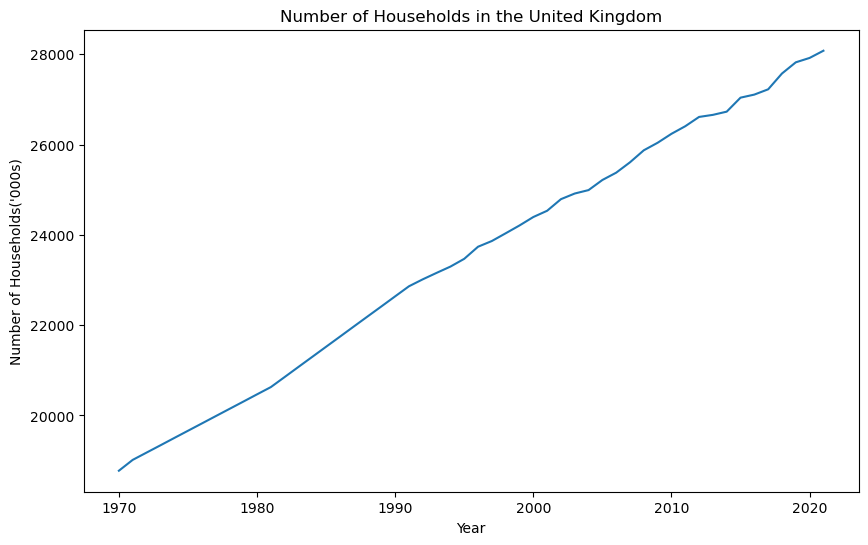

In [251]:
plotter_func(Households_df, ylabel="Number of Households('000s)", title='Number of Households in the United Kingdom');

#### The households are continously on the increase in the UK which would lead to more increase in electricity

# Accoung for Renewable Energy Projects

In [252]:
ren_energy= pd.read_csv('repd-january-2023.csv', encoding='latin1', usecols =['Operator (or Applicant)','Development Status (short)','Operational'])
ren.tail()

,Operator (or Applicant),Development Status (short),Operational
8482,Thorpe Park Solar Farm Limited,Application Submitted,NaN
8483,A M Duguid & Son,Application Submitted,NaN
8484,Swansea Bay University Health Board,Application Submitted,NaN
8485,JBM Solar Projects Limited,Application Submitted,NaN
8486,The Headland Hotel,Application Submitted,NaN


In [253]:
ren_Project = ren_energy.dropna(subset=['Operational']).copy()

# Extract the Day the project became operational
ren_Project.loc[:, 'Year'] = pd.PeriodIndex(ren_Project['Operational'], freq='D').to_timestamp()

# Limit to projects that are only operational
ren_Project = ren_Project.loc[ren_Project['Development Status (short)'] == 'Operational']

# Group by date and count the projects operational per year
ren_Project = ren_Project.groupby('Year')[['Operator (or Applicant)']].count()

# Create a running total column
ren_Project['Total_Renew_Projects'] = ren_Project['Operator (or Applicant)'].cumsum()

# Drop the Operator column
ren_Project = ren_Project.drop(columns=['Operator (or Applicant)'])

# Resample to add missing days and fill NaN values with the previous non-NaN value
ren_Project = ren_Project.resample('D').last().fillna(method='ffill').astype(int)

# Print the last 5 records
print(ren_Project.head())

            Total_Renew_Projects
Year                            
1906-01-01                     1
1906-01-02                     1
1906-01-03                     1
1906-01-04                     1
1906-01-05                     1


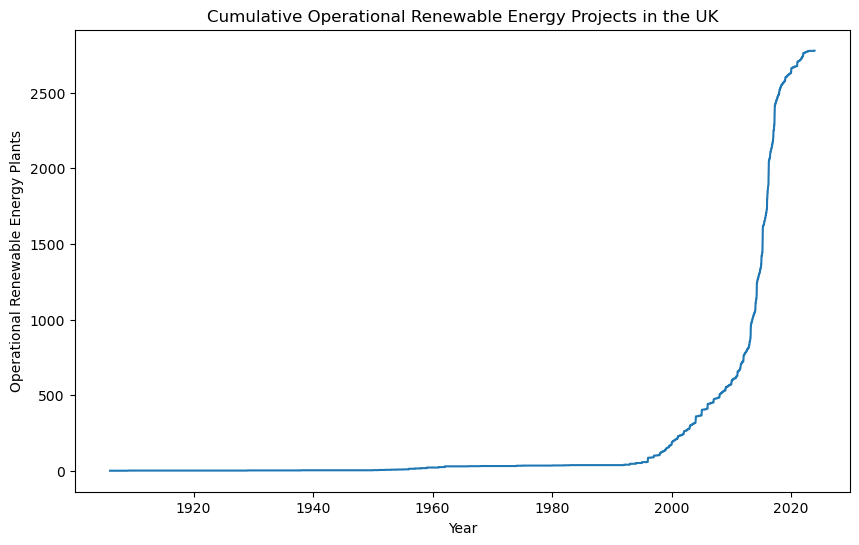

In [254]:
plotter_func(ren_Project, ylabel='Operational Renewable Energy Plants', title='Cumulative Operational Renewable Energy Projects in the UK');

#### There has been surge in investments and approval of renewable energy plants since the early 2000s

### Feed in Tariff policy (FiTP)

In [255]:
# getting the data from the statistical website
url = "https://www.gov.uk/government/statistics/solar-photovoltaics-deployment"

# send a GET request to the URL and get the HTML response
response = requests.get(url)

# parse the HTML response using Beautiful Soup
soup = BeautifulSoup(response.text, "html.parser")

# find the link to the Excel file
excel_link_elem = soup.find("a", string="Solar photovoltaics deployment (Excel)")

# get the href attribute of the link and read the Excel file into a pandas ExcelFile object
if excel_link_elem is not None:
    excel_link = excel_link_elem.get("href")
    excel_content = requests.get(excel_link).content
    fit_doc = pd.ExcelFile(BytesIO(excel_content))


else:
    print("No Excel file found on this page")

In [256]:
# the sheet of interest is the seventh sheet
fitp_df=pd.read_excel(fit_doc, fit_doc.sheet_names[8], header=4)
fitp_df.head()

,CUMULATIVE CAPACITY (MW) [note 1],Jan \n2010,Feb \n2010,Mar \n2010,Apr \n2010,May \n2010,Jun \n2010,Jul \n2010,Aug \n2010,Sep \n2010,...,Jul\n2022,Aug\n2022,Sep\n2022,Oct\n2022,Nov\n2022,Dec\n2022,Jan\n2023,Feb\n2023,Mar\n2023,Apr\n2023
0,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0 to ≤ 4 kW,8.46,9.59,11.49,13.72,17.21,21.49,26.74,31.98,38.77,...,3002.52,3028.35,3059.21,3088.44,3120.80,3145.19,3178.81,3214.50,3254.69,3279.89
2,4 to ≤ 10 kW,2.27,2.39,2.58,2.70,2.92,3.18,3.36,3.61,3.83,...,396.42,411.44,429.10,449.05,471.73,489.93,515.45,542.23,572.87,592.69
3,10 to ≤ 50 kW,2.46,2.63,3.05,3.33,3.79,4.08,4.37,4.70,5.23,...,1009.12,1016.45,1024.41,1031.95,1041.36,1048.39,1057.98,1069.58,1084.59,1094.03
4,50 kW to ≤ 5 MW,1.03,1.03,1.03,1.03,1.20,2.00,2.15,2.15,2.15,...,3665.14,3665.14,3665.14,3665.14,3665.14,3665.14,3665.14,3665.14,3665.14,3665.14


In [257]:
FiTP=(fitp_df
     #Select the Total cumulative capacity generated in the UK
     .loc[fitp_df.index ==43]
     #clean columns
     .rename(columns = lambda x: x.replace('\n', ''))
     .rename(columns = lambda x: x.replace('June', 'Jun'))
      #drop superfluous column
     .drop(columns=['CUMULATIVE CAPACITY (MW) [note 1]'])
      #remove extraspacing for proper conversion to datetime
     .rename(columns = lambda x: x.replace(' ', '')) 
      #Transpose to set the date as the index
     .T
      #rename column
     .rename(columns= {43: 'FiTP_Deployments'})
      #convert index to datetime
     .pipe(lambda df: df.set_index((pd.to_datetime(df.index, format='%b%Y'))))
     .resample('D').sum()
    )

FiTP.head()
 

,FiTP_Deployments
2010-01-01,250
2010-01-02,0
2010-01-03,0
2010-01-04,0
2010-01-05,0


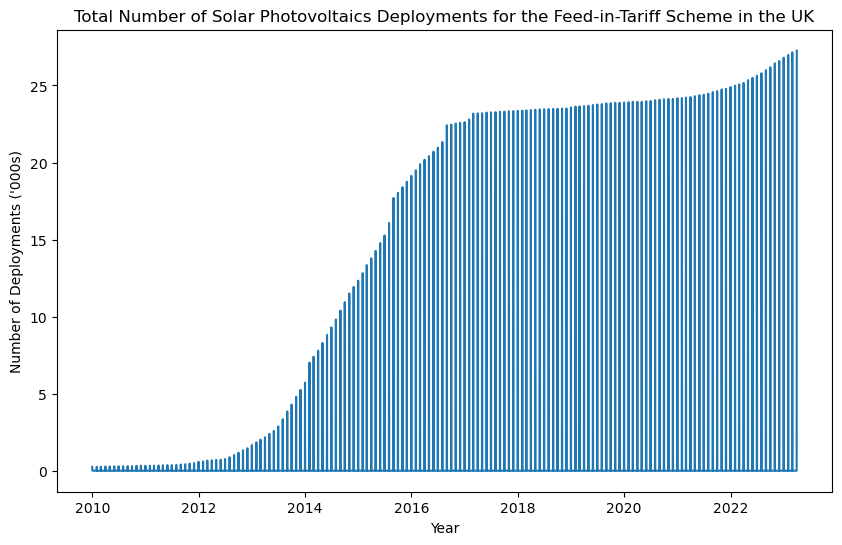

In [258]:
plotter_func(FiT/1000, ylabel="Number of Deployments ('000s)", title='Total Number of Solar Photovoltaics Deployments for the Feed-in-Tariff Scheme in the UK');

### Renewable Heat Incentive

In [259]:
ren_heat_inc=pd.ExcelFile('RHI_monthly_official_stats_tables_Dec_22.xlsx')

In [261]:
ren_heat_inc_df=pd.read_excel(rhi, 'M1.1', header=5)
ren_heat_inc_df.head()

,Year,Month,Quarter of year,Number of full applications (by date of first submission),Cumulative number of full applications,Total installed capacity (MW) of full applications (by date of first submission),Cumulative installed capacity of full applications,Number of \naccredited \nfull applications \n(by date of \nfirst approval),Cumulative number of accredited full applications,Total installed capacity of accredited full applications (MW) (by date of first approval),Cumulative installed capacity of accredited full applications
0,2011,November,2011Q4,7,7.00,11.23,11.23,0,0.00,0.00,0.00
1,2011,December,2011Q4,39,46.00,26.46,37.69,2,2.00,0.03,0.03
2,2012,January,2012Q1,63,109.00,32.88,70.57,3,5.00,0.45,0.47
3,2012,February,2012Q1,88,197.00,16.41,86.98,2,7.00,0.10,0.57
4,2012,March,2012Q1,81,278.00,16.88,103.86,11,18.00,1.80,2.37


In [262]:
Ren_Heat_Incentive= (ren_heat_inc_df
          #select columns of interest
          .loc[:,['Year','Month','Cumulative number of accredited full applications']]
          #create new date time variable of the year and month
          .assign(Date =lambda df: pd.to_datetime((df.Year.map(str) + ' ' +df.Month)))
          #select the columns of interest
          .loc[:,['Date','Cumulative number of accredited full applications']]
          .rename(columns={'Date': 'Year', 'Cumulative number of accredited full applications': 'RHI_Deployments'})
          .set_index('Year')
          #filter out the first month since there was no installation
          .loc[lambda df: df.index> '2011-11-01']
          #change the frequency to daily for subsequent interpolation while merging
          .resample('D').sum()
    )
Ren_Heat_Incentive.tail()

,RHI_Deployments
Year,
2022-11-27,0.00
2022-11-28,0.00
2022-11-29,0.00
2022-11-30,0.00
2022-12-01,22340.00


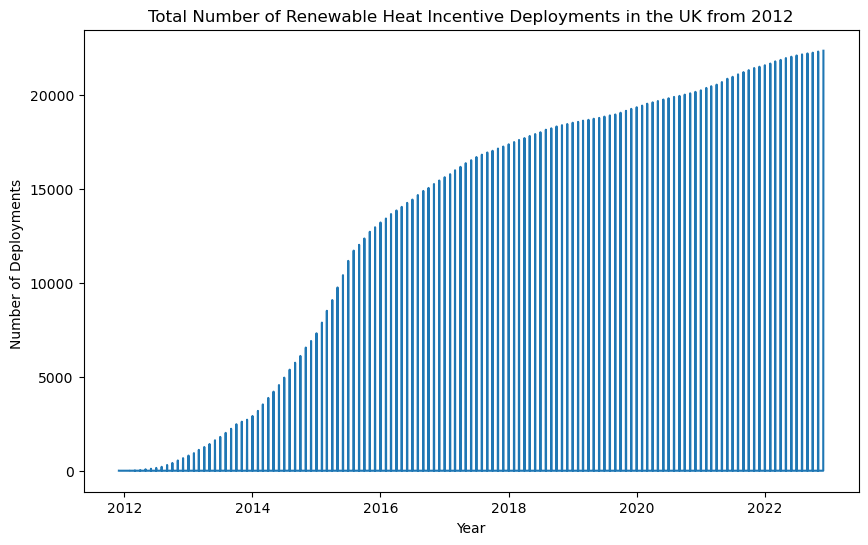

In [263]:
plotter_func(Ren_Heat_Incentive, ylabel="Number of Deployments ", title='Total Number of Renewable Heat Incentive Deployments in the UK from 2012');

### Merging all dataset that contains all government interventions/inscentives

In [264]:
Gov_Incentive =(FiTP
     .merge(RHI, left_index=True,right_index=True, how='outer').fillna(0)
     .assign(Total_Deployments = lambda df: df.FiTP_Deployments +df.RHI_Deployments)
     .loc[:,['Total_Deployments']]
     .replace(0,np.nan)
     .resample('D').last().fillna(method='ffill').astype(int)

)
Gov_Incentive.head()

,Total_Deployments
2010-01-01,250
2010-01-02,250
2010-01-03,250
2010-01-04,250
2010-01-05,250


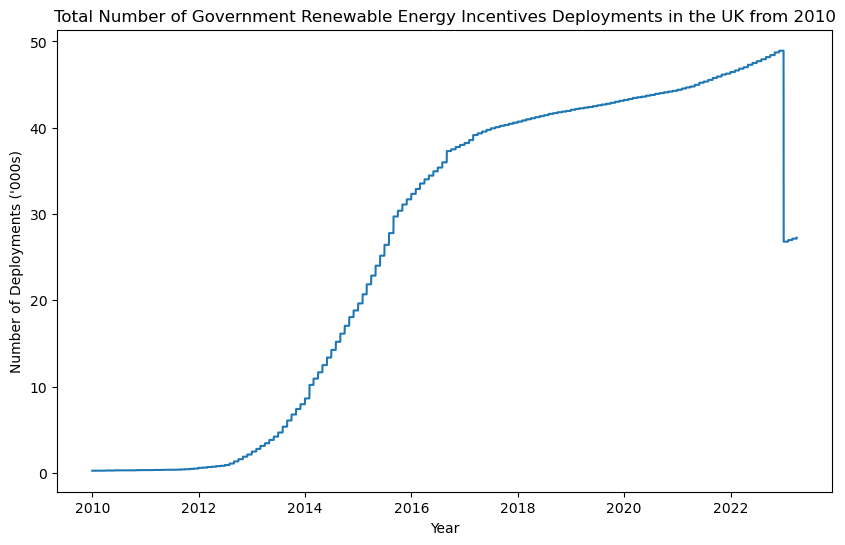

In [265]:
plotter_func(Gov_Incentive/1000, ylabel="Number of Deployments ('000s)", title='Total Number of Government Renewable Energy Incentives Deployments in the UK from 2010');

####  The  decline is attributed to the discontinuation of the FiTP and RHE policies

# Electricity Generation Mix in Northern Ireland

In [266]:
# Send a request to the URL
url20 = "https://www.economy-ni.gov.uk/publications/northern-ireland-renewable-electricity-data-tables"
response7 = requests.get(url20)

# Parse HTML content using Beautiful Soup
soup20 = BeautifulSoup(response7.content, 'html.parser')

# Find the <a> tag in the <div class='nigovfile clearfix'> section
data_tables = soup20.find('div', class_='nigovfile clearfix')
if data_tables is not None:  # Fixed variable name from 'data_table' to 'data_tables'
    first_a = data_tables.find('a')
    if first_a is not None:
        # Get the href attribute of the first <a> tag
        download_url = first_a['href']

        # Load the Excel file into a DataFrame
        NI = pd.ExcelFile(download_url)
    else:
        print("No <a> tag found in <div class='nigovfile clearfix'>")
else:
    print("No <div class='nigovfile clearfix'> found")

In [267]:
northern_Ireland_df =pd.read_excel(NI, header=2)
Northern_gen_mix =(northern_Ireland_df
     #perform preliminary cleaning and selection
     .drop(columns=['Unnamed: 0'])
     .dropna(subset=['Unnamed: 1'], axis=0)
     .reset_index(drop=True)
     .loc[lambda df: df.index .isin([2,3])]
     .T
     .pipe(lambda df: df.rename(columns =df.iloc[0]))
     .iloc[1:]
     #create a non_renewable energy variable and convert it to megawats from gigawatts
     .assign(NI_Non_Renewable_Energy = lambda df: (df['Total Electricity Consumption (GWh)'] -df['Total Renewable Electricity Generated (GWh)'])*1000)
     .rename(columns={'Total Renewable Electricity Generated (GWh)': 'NI_Renewable_Energy'})
     #convert the renamed column to megawatt
     .assign(NI_Renewable_Energy = lambda df: df.NI_Renewable_Energy*1000)
     .loc[:,['NI_Renewable_Energy','NI_Non_Renewable_Energy']]
     .rename(index =lambda x: pd.to_datetime(x))
     .resample('D').last().interpolate(method='spline', order=1)
)

Northern_gen_mix.tail()

,NI_Renewable_Energy,NI_Non_Renewable_Energy
2023-02-25,282529.21,395839.32
2023-02-26,279452.04,401021.03
2023-02-27,276374.88,406202.74
2023-02-28,273297.72,411384.45
2023-03-01,270220.40,416566.19


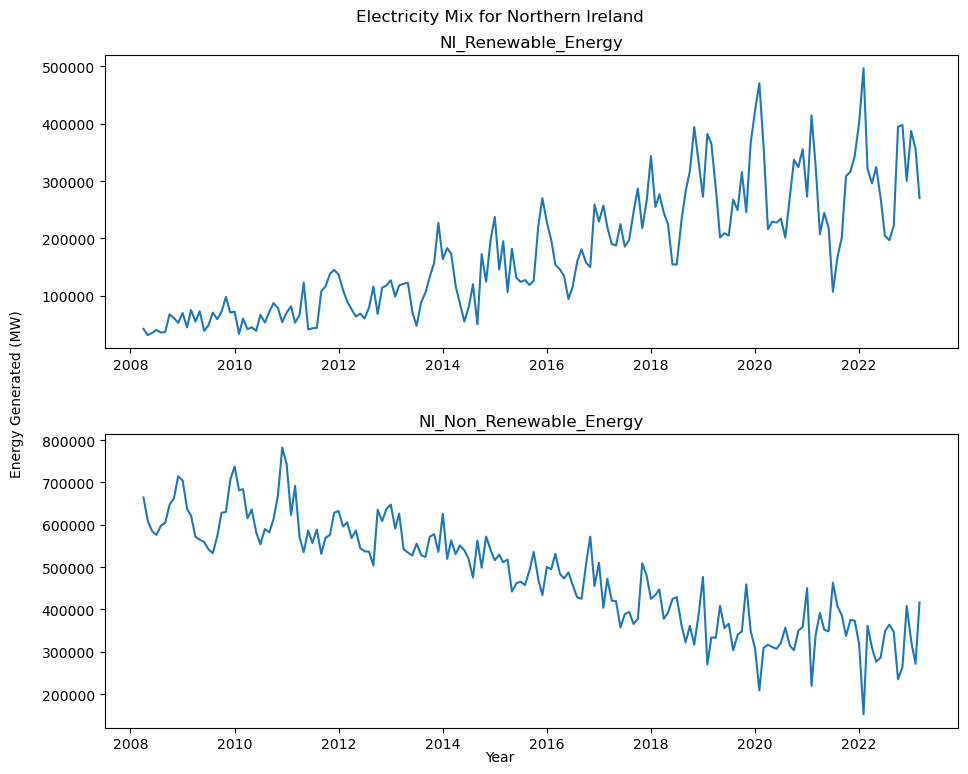

In [268]:
# create a figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# loop over each time series column and plot it in its own subplot
for i, col in enumerate(NI_gen_mix.columns):
    axs[i].plot(Northern_gen_mix.index, Northern_gen_mix[col])
    axs[i].set_title(col)

# set common x and y axis labels
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(0.01, 0.5, 'Energy Generated (MW)', va='center', rotation='vertical')

# adjust layout and padding
fig.tight_layout(pad=3.0)

plt.suptitle("Electricity Mix for Northern Ireland");

### Getting the target variable of Total emissions

In [269]:
emission_df =pd.read_csv('total-ghg-emissions.csv')
emission_df.head()

,Entity,Code,Year,Annual greenhouse gas emissions
0,Afghanistan,AFG,1851,7373214.50
1,Afghanistan,AFG,1852,7422393.50
2,Afghanistan,AFG,1853,7483595.50
3,Afghanistan,AFG,1854,7532321.00
4,Afghanistan,AFG,1855,7580708.50


In [270]:
Emission =(emission_df
            .loc[(emission_df.Entity == 'United Kingdom')] 
            #drop superfluous columns
            .drop(columns =['Code', 'Entity'])
            #Convert 'Year' to quarterly date and shift the values to the last quarter
            .assign(Year = lambda df: pd.PeriodIndex(df.Year, freq='D').to_timestamp())
            #Set the 'Year' variable as the index for the dataframe
            .set_index('Year')
            #rename column
            .rename(columns = {'Annual greenhouse gas emissions': 'Emissions'})
         )
Emission.tail()

,Emissions
Year,
2017-01-01,468639260.00
2018-01-01,461129900.00
2019-01-01,447188200.00
2020-01-01,405697730.00
2021-01-01,420895070.00


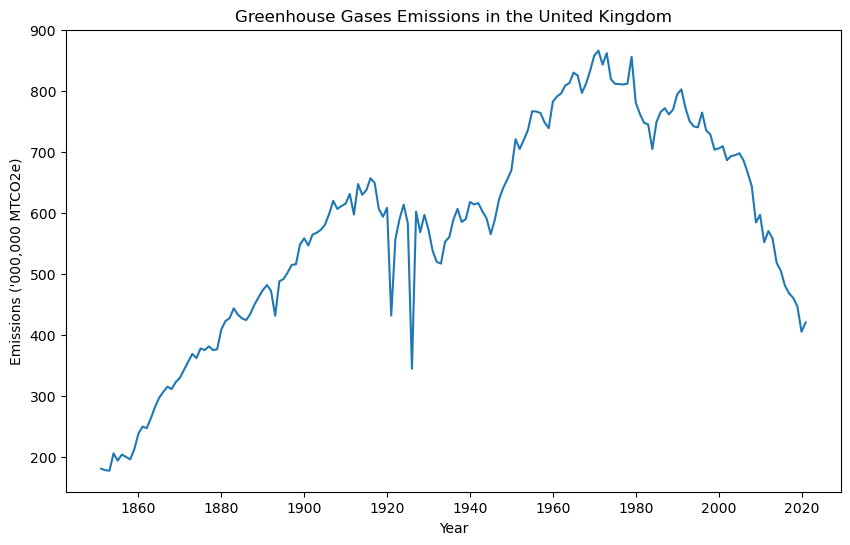

In [271]:
plotter_func(Emission/1000000, title='Greenhouse Gases Emissions in the United Kingdom',ylabel="Emissions ('000,000 MTCO2e)");

#### The plot shows that emission is decreasing gradually but it is unknown whether it will meet the target within the estimated time

# Merging all data gathered

In [272]:
net_zero_final=(Elec_Gen_Mix
 .merge(Households_df,left_index=True, right_index=True, how='outer')
 .merge(ren_Project,left_index=True, right_index=True, how='outer')
 .merge(Gov_Incentive,left_index=True, right_index=True, how='outer') 
 .merge(Northern_gen_mix,left_index=True, right_index=True, how='outer')
 .merge(Emission,left_index=True, right_index=True, how='outer')
  #start when the government incentives begin
 .loc[lambda df: df.index >='2010-01-01']
 #convert renewable projects to integer
 .assign(Total_Renew_Projects = lambda df: df.Total_Renew_Projects.astype(int))
 #fill the missing data with relevant methods
 .assign(Households_df = lambda df: df.Households.interpolate(method='spline', order=1).astype(int))
 .assign(Total_Deployments = lambda df: df.Total_Deployments.fillna(method='ffill').astype(int))
 .assign(Emissions = lambda df: df.Emissions.interpolate(method='spline', order=1))
 #Merge the Great Britain and Northern Ireland mix together and convert NI NAN values to 0
 .assign(Total_Renewable_Energy = lambda df: df.GB_Renewable_Energy + np.nan_to_num(df.NI_Renewable_Energy))
 .assign(Total_Non_Renewable_Energy = lambda df: df.GB_Non_Renewable_Energy + np.nan_to_num(df.NI_Non_Renewable_Energy))
 .dropna(subset=['GB_Renewable_Energy','GB_Non_Renewable_Energy','Nuclear_Energy_et_al'], axis=0)
  #select the necessary columns and re-arrange
 .loc[:,['Total_Renewable_Energy', 'Total_Non_Renewable_Energy', 'Nuclear_Energy_et_al', 'Households_df', 'Total_Renew_Projects','Total_Deployments','Emissions']]
 )

net_zero_final.head()
print(net_zero_final.shape)

(4944, 7)


In [273]:
net_zero_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4944 entries, 2010-01-01 to 2023-07-15
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Total_Renewable_Energy      4944 non-null   float64
 1   Total_Non_Renewable_Energy  4944 non-null   float64
 2   Nuclear_Energy_et_al        4944 non-null   float64
 3   Households_df               4944 non-null   int32  
 4   Total_Renew_Projects        4944 non-null   int32  
 5   Total_Deployments           4944 non-null   int32  
 6   Emissions                   4944 non-null   float64
dtypes: float64(4), int32(3)
memory usage: 251.1 KB


In [274]:
net_zero_final.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Total_Renewable_Energy,4944.00,613234.40,340582.02,53472.25,333142.57,582936.18,839580.41,1669563.73
Total_Non_Renewable_Energy,4944.00,1333513.31,467038.10,46311.00,988489.77,1293128.34,1669211.70,2758481.54
Nuclear_Energy_et_al,4944.00,340723.19,78244.59,74303.00,277906.50,341131.50,402185.00,519542.00
Households_df,4944.00,27333.39,671.74,26240.00,26687.00,27199.00,27945.25,28483.00
Total_Renew_Projects,4944.00,1863.71,832.95,575.00,983.00,2144.00,2664.00,2777.00
Total_Deployments,4944.00,26358.30,18251.69,250.00,3820.00,33541.00,42692.00,48929.00
Emissions,4944.00,487277228.40,54378464.38,405697730.00,443306861.70,471597561.78,543464650.44,597291400.00


In [275]:
net_zero_final.isnull().value_counts().sum()

4944

### Checking for relationship using Correlation

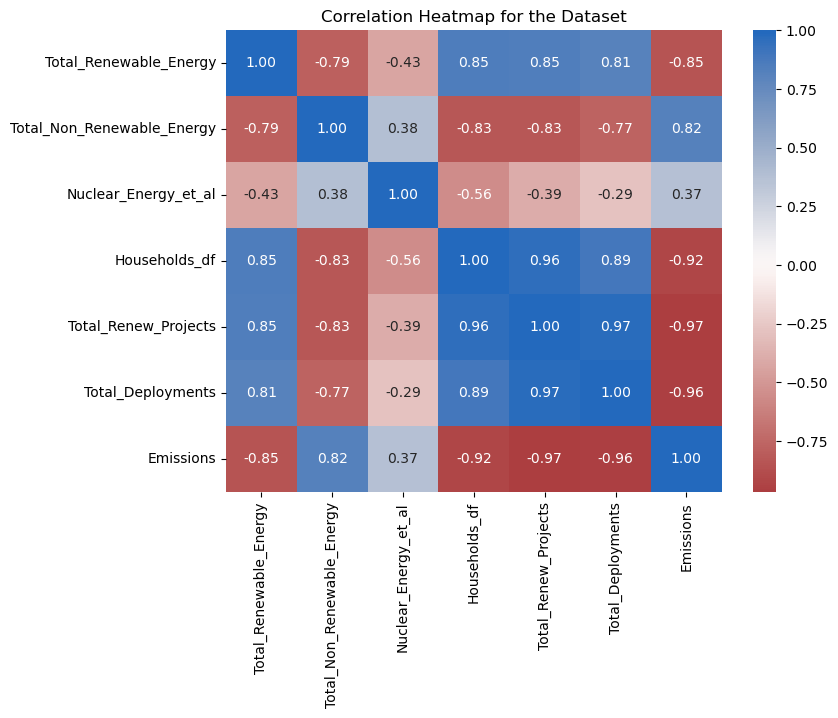

In [276]:
plt.figure(figsize = [8, 6])
sns.heatmap(net_zero_final.corr(), annot=True,fmt = '.2f',
           cmap = 'vlag_r', center = 0)
plt.title('Correlation Heatmap for the Dataset');

In [277]:
corr =net_zero_final.corrwith(net_zero_final.Emissions)

In [278]:
corr.abs().sort_values(ascending=True)

Nuclear_Energy_et_al         0.37
Total_Non_Renewable_Energy   0.82
Total_Renewable_Energy       0.85
Households_df                0.92
Total_Deployments            0.96
Total_Renew_Projects         0.97
Emissions                    1.00
dtype: float64

## Save the new dataset as a csv file

In [281]:
net_zero_final.to_csv('net_zero_final12.csv')